# Sentimen Analysis (Mobile Legend App Review)


*   Nama            : Reza Faisal
*   Email : rezha.faizal567@gmail.com
* ID Dicoding : rezaafaisal



In [1]:
!uv venv
!source venv/bin/activate

Using CPython 3.10.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
/bin/bash: line 1: venv/bin/activate: No such file or directory


In [2]:
!uv pip install --system Sastrawi

Using Python 3.10.12 environment at /usr
Resolved 1 package in 109ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 42ms
Installed 1 package in 3ms
 + sastrawi==1.0.1


In [3]:
import numpy as np
import polars as pl
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Gathering

In [5]:
# load dataset
dirty_df = pl.read_csv("/content/drive/MyDrive/Datasets/ml_reviews.csv")

In [6]:
dirty_df.sample(5)

userName,content,score,thumbsUpCount,at
str,str,i64,i64,str
"""Radit Saja""","""Saya mengalami sinyal tidak st…",1,10,"""2024-10-26T06:54:50.000000"""
"""Pengguna Google""","""MOONTON ko gini game nya, dari…",1,0,"""2024-11-11T07:03:18.000000"""
"""Aril""","""Game nya seru banyak skin grat…",5,0,"""2024-09-23T08:03:24.000000"""
"""Pengguna Google""","""Game nya sangat seru dan banya…",5,0,"""2024-09-21T12:46:41.000000"""
"""Pengguna Google""","""DEAR PIHAK DEVELOPER setiap dr…",1,0,"""2024-10-15T11:44:57.000000"""


## Data Preprocessing

In [7]:
# correct date type
formatted_df = dirty_df.with_columns(pl.col("at").str.to_datetime())
formatted_df.schema

Schema([('userName', String),
        ('content', String),
        ('score', Int64),
        ('thumbsUpCount', Int64),
        ('at', Datetime(time_unit='us', time_zone=None))])

### Cleaning Text

In [8]:
formatted_df = formatted_df.with_columns(
    (pl.col("content").map_elements(lambda x: re.sub('[^A-Za-z]+', ' ', x))).alias("only_text"), # remove punctuation
)

formatted_df = formatted_df.with_columns(
    (pl.col("only_text")
      .str.strip_chars()
      .str.to_lowercase())
    .alias('lower'), # convert to lowercase
)

formatted_df = formatted_df.with_columns(
    (pl.col('lower').map_elements(lambda x: word_tokenize(x))).alias('tokenized')
)

formatted_df.head()
cleaned_df = formatted_df

<ipython-input-8-17a150bde958>:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  formatted_df = formatted_df.with_columns(
<ipython-input-8-17a150bde958>:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  formatted_df = formatted_df.with_columns(


In [9]:
abbreviation_dict = {
    "bgs": "bagus",
    "kcwa": "kecewa",
    "skrg": "sekarang",
    "sblm": "sebelum",
    "smg": "semoga",
    "tdk": "tidak",
    "ga": "tidak",
    "gk": "tidak",
    "lbh": "lebih",
    "dr": "dari",
    "kmrn": "kemarin",
    "bs": "bisa",
    "gmn": "gimana",
    "knp": "kenapa",
    "dmn": "dimana",
    "lg": "lagi",
    "krn": "karena",
    "kl": "kalau",
    "bgt": "banget",
    "msh": "masih",
    "pls": "please",
    "org": "orang",
    "jd": "jadi",
    "ntar": "nanti",
    "dpt": "dapat",
    "sj": "saja",
    "trm": "terima",
    "trnyata": "ternyata",
    "bkn": "bukan",
    "hrs": "harus",
    "prnh": "pernah",
    "blm": "belum",
    "tlg": "tolong",
    "pgn": "pengen",
    "kyk": "kayak",
    "sm": "sama",
    "aj": "saja",
    "apk": "aplikasi",
    "tp": "tapi",
    "km": "kamu",
    "y": "ya",
    "gitu": "begitu",
    "ok": "oke",
    "udh": "sudah",
    "smua": "semua"
}


### Formatted Text

In [10]:
cleaned_df = cleaned_df.with_columns((pl.col('tokenized').map_elements(lambda x: [word for word in x if word not in stopwords.words('indonesian')])).alias('no_stopwords'))
cleaned_df = cleaned_df.with_columns((pl.col('no_stopwords').map_elements(lambda x: [abbreviation_dict.get(word, word) for word in x])).alias('abbreviation'))

<ipython-input-10-197b9ba0e34c>:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  cleaned_df = cleaned_df.with_columns((pl.col('tokenized').map_elements(lambda x: [word for word in x if word not in stopwords.words('indonesian')])).alias('no_stopwords'))
<ipython-input-10-197b9ba0e34c>:4: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  cleaned_df = cleaned_df.with_columns((pl.col('no_stopwords').map_elements(lambda x: [abbreviation_dict.get(word, word) for word in x])).alias('abbreviation'))


In [11]:
# stemming
stemmer = StemmerFactory().create_stemmer()
cleaned_df = cleaned_df.with_columns((pl.col('abbreviation').map_elements(lambda x: [stemmer.stem(word) for word in x])).alias('stemmed'))

<ipython-input-11-d29334377b29>:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  cleaned_df = cleaned_df.with_columns((pl.col('abbreviation').map_elements(lambda x: [stemmer.stem(word) for word in x])).alias('stemmed'))


In [28]:
cleaned_df = cleaned_df.with_columns((pl.col('stemmed').map_elements(lambda x: ' '.join(x), return_dtype=pl.Utf8)).alias('formatted'))

In [29]:
cleaned_df.sample(5)

userName,content,score,thumbsUpCount,at,only_text,lower,tokenized,no_stopwords,abbreviation,stemmed,formatted
str,str,i64,i64,datetime[μs],str,str,list[str],list[str],list[str],list[str],str
"""Pengguna Google""","""Kecewa gua main 3 tahun tapi m…",1,0,2024-10-13 05:28:38,"""Kecewa gua main tahun tapi mas…","""kecewa gua main tahun tapi mas…","[""kecewa"", ""gua"", … ""dineraka""]","[""kecewa"", ""gua"", … ""dineraka""]","[""kecewa"", ""gua"", … ""dineraka""]","[""kecewa"", ""gua"", … ""neraka""]","""kecewa gua main ngestuck epic …"
"""Meri Anggrahini""","""Montoon balikin match making k…",1,1,2024-11-13 15:49:55,"""Montoon balikin match making k…","""montoon balikin match making k…","[""montoon"", ""balikin"", … ""itu""]","[""montoon"", ""balikin"", … ""lo""]","[""montoon"", ""balikin"", … ""lo""]","[""montoon"", ""balikin"", … ""lo""]","""montoon balikin match making k…"
"""Pengguna Google""","""Jangan di update terus dong, k…",1,56,2024-06-20 16:14:18,"""Jangan di update terus dong ka…","""jangan di update terus dong ka…","[""jangan"", ""di"", … ""lagi""]","[""update"", ""kasihan"", … ""mainin""]","[""update"", ""kasihan"", … ""mainin""]","[""update"", ""kasihan"", … ""mainin""]","""update kasihan orang yg ram ny…"
"""Pengguna Google""","""Game nya bagus cuma ada sesuat…",2,74,2024-09-23 15:51:46,"""Game nya bagus cuma ada sesuat…","""game nya bagus cuma ada sesuat…","[""game"", ""nya"", … ""pertandingan""]","[""game"", ""nya"", … ""pertandingan""]","[""game"", ""nya"", … ""pertandingan""]","[""game"", ""nya"", … ""tanding""]","""game nya bagus kadang kesel ga…"
"""Pengguna Google""","""kecewa sama mlbb yang skarang …",3,1,2024-11-02 09:59:18,"""kecewa sama mlbb yang skarang …","""kecewa sama mlbb yang skarang …","[""kecewa"", ""sama"", … ""terus""]","[""kecewa"", ""mlbb"", … ""computer""]","[""kecewa"", ""mlbb"", … ""computer""]","[""kecewa"", ""mlbb"", … ""computer""]","""kecewa mlbb skarang karna main…"


### Labelling Text

In [35]:
negative_words = [
    "lag", "lemot", "buruk", "parah", "kecewa", "sampah",
    "toxic", "bug", "banyak bug", "curang", "pay to win",
    "tidak adil", "berat", "crash", "force close",
    "disconnect", "tidak responsif", "tidak stabil",
    "bosan", "pelit", "membosankan", "tidak puas",
    "tidak balance", "matchmaking buruk", "toxix", "toxic player",
    "pay to win", "tidak balance", "tidak adil", "membosankan",
    "toxic", "parah", "server jelek", "tidak worth", "merugikan",
    "tidak sesuai", "p2w", "menyebalkan", "tidak seru",
    "menyulitkan", "hancur", "pelit", "tidak menarik", "lelet",
    "tidak berguna", "tidak layak", "aneh", "tidak berfungsi",
    "tidak memuaskan", "mengecewakan", "tidak responsif",
    "tidak seimbang", "curang", "tidak profesional", "overprice",
    "tim buruk", "teman noob", "matchmaking kacau", "susah menang",
    "tidak menyenangkan", "menjengkelkan", "frustasi", "tidak optimal",
    "tidak kompatibel", "kacau", "delay", "diskriminasi", "error",
    "rusak", "lawak", "beban", "tolol", "bodo", "bodoh", "jorok",
    "kotor", "tidak becus", "becus", "jelek", "nglag", "ngelag",
    "payah", "ngawur", "emosi"
]

positive_words = [
    "seru", "menyenangkan", "bagus", "mantap", "keren", "hebat",
    "luar biasa", "menarik", "asyik", "canggih", "memuaskan",
    "puas", "terbaik", "top", "stabil", "fast", "responsive",
    "smooth", "rewarding", "gratis", "ringan", "strategis",
    "kompetitif", "grafik bagus", "teamwork", "baik", "lancar",
    "menakjubkan", "amazing", "bagus sekali", "sangat baik",
    "sangat puas", "efektif", "berkualitas", "recommended",
    "favorit", "luar biasa", "menawan", "inovatif", "menghibur",
    "super", "berkesan", "memuaskan sekali", "terjangkau",
    "mengagumkan", "fun", "cool", "fantastis", "top banget",
    "user friendly", "mudah digunakan", "fair", "adil",
    "balancing bagus", "kompetitif", "epic", "menyenangkan sekali",
    "grafik keren", "smooth gameplay", "rewarding", "tim solid",
    "teamwork bagus", "supportive", "kreatif", "menantang",
    "worth it", "pengalaman luar biasa", "addictive", "terus berkembang",
    "cepat tanggap", "update keren", "peningkatan signifikan"
]

In [36]:
def set_label(words):
  score = 0
  for word in words:
    if word in negative_words:
      score -= 1
    elif word in positive_words:
      score += 1

  if score > 0:
    return "positive"
  elif score < 0:
    return "negative"
  else:
    return "neutral"

In [37]:
labelled_df = cleaned_df.with_columns((pl.col('stemmed').map_elements(set_label, return_dtype=pl.Utf8)).alias('label'))

In [84]:
labelled_df.sample(5)

userName,content,score,thumbsUpCount,at,only_text,lower,tokenized,no_stopwords,abbreviation,stemmed,formatted,label
str,str,i64,i64,datetime[μs],str,str,list[str],list[str],list[str],list[str],str,str
"""Pengguna Google""","""Gajelas jaringan nya main ini …",2,1,2024-10-30 00:26:48,"""Gajelas jaringan nya main ini …","""gajelas jaringan nya main ini …","[""gajelas"", ""jaringan"", … ""merah""]","[""gajelas"", ""jaringan"", … ""merah""]","[""gajelas"", ""jaringan"", … ""merah""]","[""gajelas"", ""jaring"", … ""merah""]","""gajelas jaring nya main lag mu…","""positive"""
"""Pengguna Google""","""Game sangat bagus grafik bagus…",5,0,2024-11-12 14:14:07,"""Game sangat bagus grafik bagus…","""game sangat bagus grafik bagus…","[""game"", ""sangat"", … ""montoon""]","[""game"", ""bagus"", … ""montoon""]","[""game"", ""bagus"", … ""montoon""]","[""game"", ""bagus"", … ""montoon""]","""game bagus grafik bagus temen …","""positive"""
"""Pengguna Google""","""Banyak yang harus di perbaiki …",4,0,2024-09-21 10:23:34,"""Banyak yang harus di perbaiki …","""banyak yang harus di perbaiki …","[""banyak"", ""yang"", … ""musuh""]","[""perbaiki"", ""segi"", … ""musuh""]","[""perbaiki"", ""segi"", … ""musuh""]","[""baik"", ""segi"", … ""musuh""]","""baik segi draft pick mana temu…","""positive"""
"""Pengguna Google""","""Game ini bagus tapi dikasih la…",3,3,2024-10-30 14:11:20,"""Game ini bagus tapi dikasih la…","""game ini bagus tapi dikasih la…","[""game"", ""ini"", … ""kesal""]","[""game"", ""bagus"", … ""kesal""]","[""game"", ""bagus"", … ""kesal""]","[""game"", ""bagus"", … ""kesal""]","""game bagus kasih kalo kasih da…","""positive"""
"""Pengguna Google""","""Saya suka dngn game ini,cmn ad…",4,0,2024-11-14 14:06:08,"""Saya suka dngn game ini cmn ad…","""saya suka dngn game ini cmn ad…","[""saya"", ""suka"", … ""lek""]","[""suka"", ""dngn"", … ""lek""]","[""suka"", ""dngn"", … ""lek""]","[""suka"", ""dngn"", … ""lek""]","""suka dngn game cmn kadang jari…","""positive"""


In [39]:
# export to csv biar ga stemming ulang wkwk
labelled_df.select(["content", "score", "formatted", "label"]) .write_csv("/content/drive/MyDrive/Datasets/ml_reviews_labelled.csv")

## Exploratory Data Anlysis

In [56]:
sentiment_counts = labelled_df.group_by("label").agg(pl.len().alias("count")).sort('label').to_pandas()

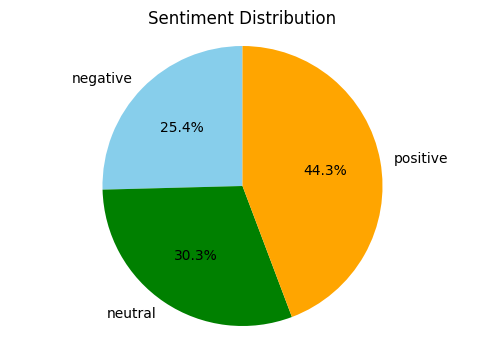

In [101]:
# distribusi sentimen
plt.figure(figsize=(6, 4))
plt.pie(sentiment_counts['count'], labels=sentiment_counts['label'], autopct="%1.1f%%", startangle=90, colors=["skyblue", "green", "orange"])
plt.title('Sentiment Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

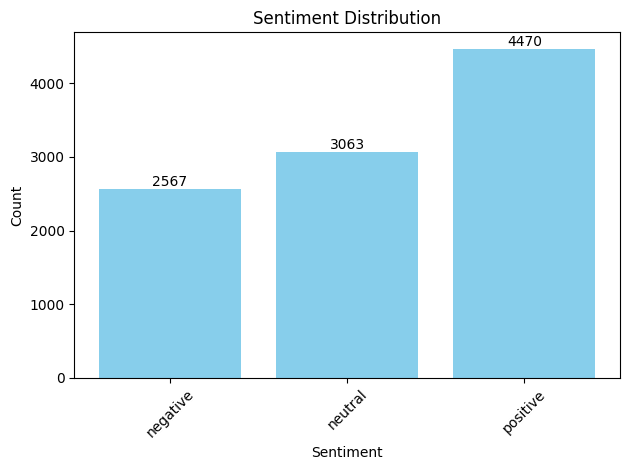

In [64]:
bars = plt.bar(sentiment_counts['label'], sentiment_counts['count'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')  # Add text annotation

plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

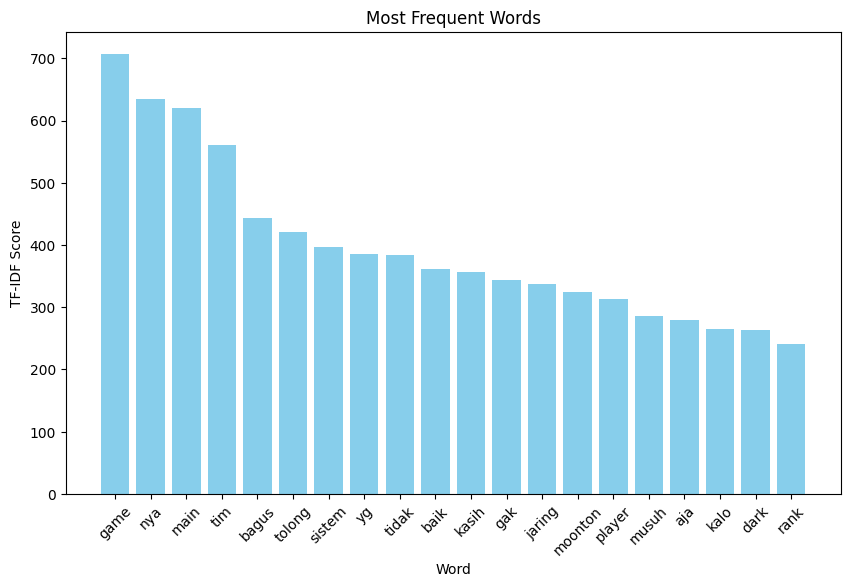

In [66]:
# most frequent words
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(labelled_df['formatted'])

tfidf_df = pl.DataFrame({'word': vectorizer.get_feature_names_out(), 'tfidf': X.toarray().sum(axis=0)})
tfidf_df = tfidf_df.sort('tfidf', descending=True)

plt.figure(figsize=(10, 6))
plt.bar(tfidf_df['word'][:20], tfidf_df['tfidf'][:20], color='skyblue')
plt.xlabel('Word')
plt.ylabel('TF-IDF Score')
plt.title("Most Frequent Words")
plt.xticks(rotation=45)
plt.show()

In [98]:
labelled_df.filter(pl.col("label") == "positive").select(pl.col("formatted")).to_series().to_list()

['pandai apa main monoton akun kena lose streak dark sistem dgn imbang match making segi jaring bintang korban bintang masuk akal tolong baik monoton logis jenuh main main nyaman',
 'bagus sih cuman kendala pas main wifi nya kenceng banget sinyal nya merah hero gak gerak pas musuh ngelag sinyal udah kenceng loh mati pas mati sinyal nya hijau yg kayak gin orang orang ngomong kasar oke aja ya mohon baik moonton makasih',
 'tolong baik sistem classic rank tim kayak warior musuh kayak miythic tambah tolong baik jaring lihat aplikasi dasar game sampah sistem cacat sekian terimakasih',
 'gamenya bagus ya kurang dianatarnya tolong jaring stabil ya jaring stabil kurang main main tolong hilang dark system dark system terus rank hadap main main tolong lawan padan',
 'game bagus keren kendala game sistem matchmaking jaring sistem matchmaking buruk terkadang jaring buruk ping ijo tpi ngeleg ping ijo ping merah gw nonton k g tuh nama ngeleg tolong baik kendala sekian terima gaji',
 'game nya bagus 

In [91]:
from wordcloud import WordCloud, ImageColorGenerator

# wordcloud
def wordcloud_draw(data: pl.DataFrame, label: str):
  words_series = data.filter(pl.col("label") == label).select(pl.col("formatted")).to_series()

  words = ' '.join(words_series.to_list())
  wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(words)
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'Wordcloud Sentiment - {label}')
  plt.show()


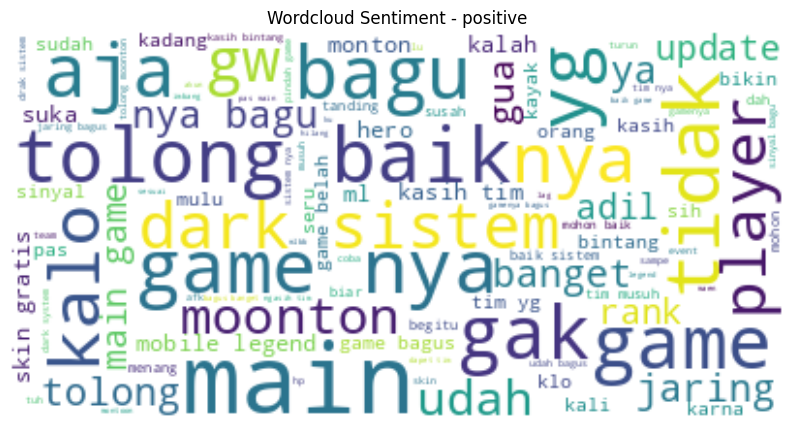

In [93]:
wordcloud_draw(labelled_df, "positive")

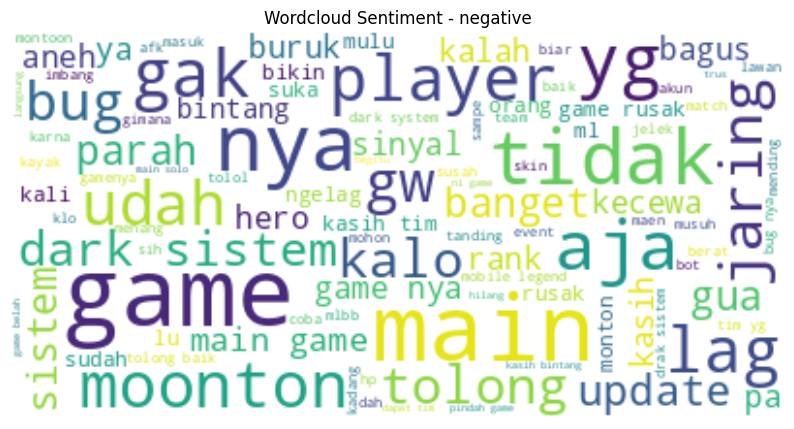

In [94]:
wordcloud_draw(labelled_df, "negative")

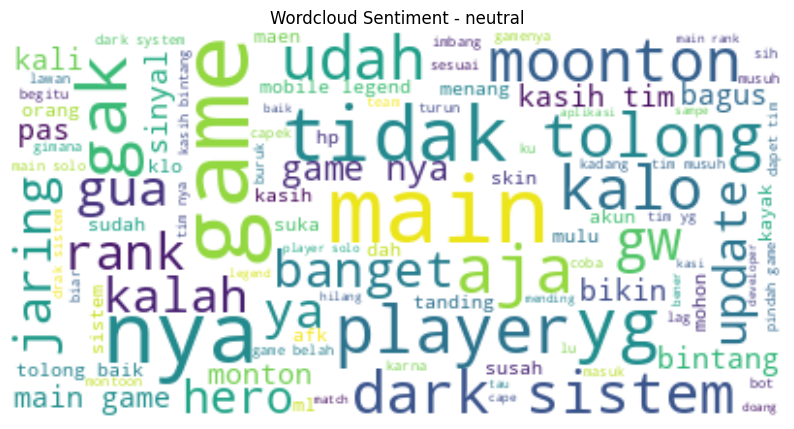

In [95]:
wordcloud_draw(labelled_df, "neutral")

## Data Preparation

In [144]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [102]:
X = labelled_df['formatted']
y = labelled_df['label']

In [116]:
# vectorizer
tfidf = TfidfVectorizer(max_features=150, min_df=20, max_df=0.7)
X_tfidf = tfidf.fit_transform(X)

In [145]:
# label encoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [146]:
y_categorical

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [119]:
X_array = X_tfidf.toarray()

# Get the feature names
feature_names = tfidf.get_feature_names_out()

# Create a Polars DataFrame
features_df = pl.DataFrame({name: X_array[:, i] for i, name in enumerate(feature_names)})

In [120]:
features_df

adil,afk,aja,akun,aneh,aplikasi,bagus,baik,banget,banyak,begitu,belah,bener,benerin,berat,biar,bikin,bintang,bot,bug,buruk,cape,capek,coba,cuman,dah,dapet,dark,data,developer,dikit,doang,download,drak,enak,epic,event,…,pro,rank,role,rusak,sampe,saran,season,seru,sesuai,sih,sinyal,sistem,skin,solo,stabil,sudah,suka,susah,system,tanding,tau,team,teman,terimakasih,tidak,tim,tolong,tpi,trus,tuh,turun,udah,ulang,update,wifi,ya,yg
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.332862,0.0,0.0,0.0,0.178771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.480797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.219278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.179499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.115567,0.0,0.0,0.0,0.097155,0.105838,0.13747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.202867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165924,0.438422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.130113,0.0,0.0,0.183796,0.138733,0.112982
0.0,0.0,0.0,0.0,0.0,0.328144,0.0,0.338095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.211874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.339472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.321027,0.0,0.148469,0.307491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.094533,0.0,0.0,0.0,0.0,0.0,0.112449,0.0,0.143906,0.143379,0.14659,0.0,0.168438,0.0,0.0,0.232838,0.0,0.0,0.0,0.0,0.0,0.155057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.108508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.14203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.380178,0.078738,0.171113,0.0,0.0,0.141219,0.0,0.0,0.0,0.0,0.113482,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.098497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.134484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428376,0.0,0.0,0.0,0.366058,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.292762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.281299,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.233346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.527596,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150339
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.487579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(features_df, y_encoded, test_size=0.2, random_state=3)

print("Train Data Shape : ", X_train.shape, y_train.shape)
print("Test Data Shape : ", X_test.shape, y_test.shape)

Train Data Shape :  (8080, 150) (8080,)
Test Data Shape :  (2020, 150) (2020,)


## Modelling

In [171]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## SVM

In [174]:
from sklearn.svm import SVC
clf_svm = SVC()

clf_svm.fit(X_train, y_train)
svm_prediction = clf_svm.predict(X_test)

In [175]:
# matriks
target_names = label_encoder.classes_
print(confusion_matrix(y_test, svm_prediction, labels=label_encoder.transform(target_names)))
print(classification_report(y_test, svm_prediction, target_names=target_names))

[[330 130  21]
 [ 33 529  56]
 [  1  74 846]]
              precision    recall  f1-score   support

    negative       0.91      0.69      0.78       481
     neutral       0.72      0.86      0.78       618
    positive       0.92      0.92      0.92       921

    accuracy                           0.84      2020
   macro avg       0.85      0.82      0.83      2020
weighted avg       0.85      0.84      0.84      2020



## Naive Bayes

In [162]:
from sklearn.naive_bayes import BernoulliNB

In [167]:
clf = BernoulliNB(force_alpha=True)

clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

In [169]:
# matriks
target_names = label_encoder.classes_
print(confusion_matrix(y_test, prediction, labels=label_encoder.transform(target_names)))
print(classification_report(y_test, prediction, target_names=target_names))

[[275 149  57]
 [ 95 403 120]
 [ 50 117 754]]
              precision    recall  f1-score   support

    negative       0.65      0.57      0.61       481
     neutral       0.60      0.65      0.63       618
    positive       0.81      0.82      0.81       921

    accuracy                           0.71      2020
   macro avg       0.69      0.68      0.68      2020
weighted avg       0.71      0.71      0.71      2020



## Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

In [149]:
model = Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [150]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
history = model.fit(X_train, y_train, epochs=10, batch_size=2, validation_data=(X_test, to_categorical(y_test)))

Epoch 1/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.5718 - loss: 0.8601 - val_accuracy: 0.8505 - val_loss: 0.4785
Epoch 2/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8289 - loss: 0.4848 - val_accuracy: 0.8678 - val_loss: 0.4486
Epoch 3/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8564 - loss: 0.4228 - val_accuracy: 0.8713 - val_loss: 0.4432
Epoch 4/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8732 - loss: 0.3801 - val_accuracy: 0.8718 - val_loss: 0.4378
Epoch 5/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8839 - loss: 0.3557 - val_accuracy: 0.8698 - val_loss: 0.4553
Epoch 6/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8831 - loss: 0.3479 - val_accuracy: 0.8752 - val_loss: 0.4494
Epoch 7/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8820 - loss: 0.3431 - val_accuracy: 0.8767 - val_loss: 0.4623
Epoch 8/10
4040/4040 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.8891 - loss: 0.

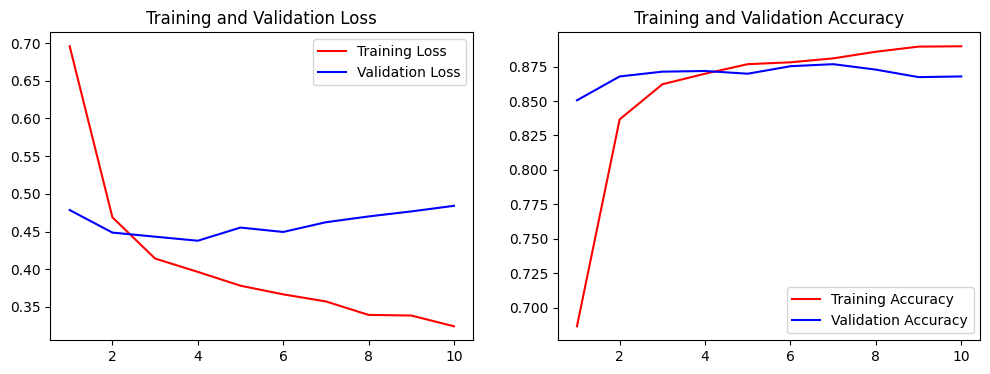

In [152]:
# visualisasi performa training dan validasi

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel='Epochs'
plt.ylabel='Accuracy'
plt.legend()

plt.show()

Berdasarkan perbandingan 3 model diatas, didapatkan hasil tertinggi dengan menggunakan algoritma Neural Network dengan akurasi 89%

## Evaluate

In [154]:
def preprocessing_sentence(sentence: str):
  sentence = re.sub('[^A-Za-z]+', ' ', sentence)
  sentence = sentence.strip().lower()
  sentence = word_tokenize(sentence)
  sentence = [word for word in sentence if word not in stopwords.words('indonesian')]
  sentence = [abbreviation_dict.get(word, word) for word in sentence]
  sentence = [stemmer.stem(word) for word in sentence]
  sentence = ' '.join(sentence)
  return sentence

In [161]:
# input sentence

sentence = input("Masukkan kelimat review anda : ")

preprocessed_sentence = preprocessing_sentence(sentence)

result = model.predict(tfidf.transform([preprocessed_sentence]).toarray())
predicted_label = np.argmax(result)

if predicted_label == 0:
  print("Sentimen : Negative")
elif predicted_label == 1:
  print("Sentimen : Neutral")
else:
  print("Sentimen : Positive")


Masukkan kelimat review anda : game ini sangat seru, tapi gampang bikin naik darah
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Sentimen : Positive
